In [1]:
import torch 
import numpy as np
from torch import nn
from torch.nn import functional as F
from sphere_initialization import generate_class_vectors
from sphere_initialization import generate_class_vectors_hemispheres
from siglip_loss import SigLIPLoss
from siglip_experiment import *
%load_ext autoreload
%autoreload 2

Using device: cpu
Running experiments with: n_classes=100, dim=10, n_epochs=10000

Testing temperature: 10.00
[100/10000]  loss=0.0048  T=10.0000  rb=0.8754
[200/10000]  loss=0.0044  T=10.0000  rb=0.8659
[300/10000]  loss=0.0043  T=10.0000  rb=0.8624
[400/10000]  loss=0.0042  T=10.0000  rb=0.8606
[500/10000]  loss=0.0042  T=10.0000  rb=0.8594
[600/10000]  loss=0.0041  T=10.0000  rb=0.8585
[700/10000]  loss=0.0041  T=10.0000  rb=0.8577
[800/10000]  loss=0.0041  T=10.0000  rb=0.8572
[900/10000]  loss=0.0041  T=10.0000  rb=0.8569
[1000/10000]  loss=0.0041  T=10.0000  rb=0.8566
[1100/10000]  loss=0.0041  T=10.0000  rb=0.8562
[1200/10000]  loss=0.0040  T=10.0000  rb=0.8559
[1300/10000]  loss=0.0040  T=10.0000  rb=0.8556
[1400/10000]  loss=0.0040  T=10.0000  rb=0.8553
[1500/10000]  loss=0.0040  T=10.0000  rb=0.8550
[1600/10000]  loss=0.0040  T=10.0000  rb=0.8548
[1700/10000]  loss=0.0040  T=10.0000  rb=0.8546
[1800/10000]  loss=0.0040  T=10.0000  rb=0.8544
[1900/10000]  loss=0.0040  T=10.000

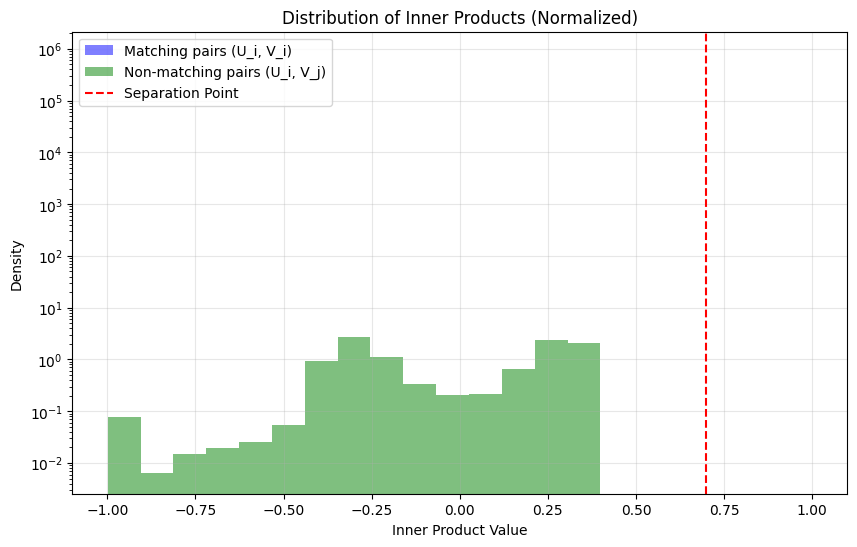


Testing temperature: 20.00
[100/10000]  loss=0.0005  T=20.0000  rb=0.7722
[200/10000]  loss=0.0004  T=20.0000  rb=0.7826
[300/10000]  loss=0.0003  T=20.0000  rb=0.7823
[400/10000]  loss=0.0003  T=20.0000  rb=0.7803
[500/10000]  loss=0.0002  T=20.0000  rb=0.7781
[600/10000]  loss=0.0002  T=20.0000  rb=0.7760
[700/10000]  loss=0.0002  T=20.0000  rb=0.7742
[800/10000]  loss=0.0002  T=20.0000  rb=0.7726
[900/10000]  loss=0.0002  T=20.0000  rb=0.7712
[1000/10000]  loss=0.0002  T=20.0000  rb=0.7700
[1100/10000]  loss=0.0002  T=20.0000  rb=0.7689
[1200/10000]  loss=0.0002  T=20.0000  rb=0.7680
[1300/10000]  loss=0.0002  T=20.0000  rb=0.7671
[1400/10000]  loss=0.0002  T=20.0000  rb=0.7664
[1500/10000]  loss=0.0002  T=20.0000  rb=0.7657
[1600/10000]  loss=0.0002  T=20.0000  rb=0.7651
[1700/10000]  loss=0.0002  T=20.0000  rb=0.7646
[1800/10000]  loss=0.0002  T=20.0000  rb=0.7641
[1900/10000]  loss=0.0002  T=20.0000  rb=0.7637
[2000/10000]  loss=0.0002  T=20.0000  rb=0.7633
[2100/10000]  loss=0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


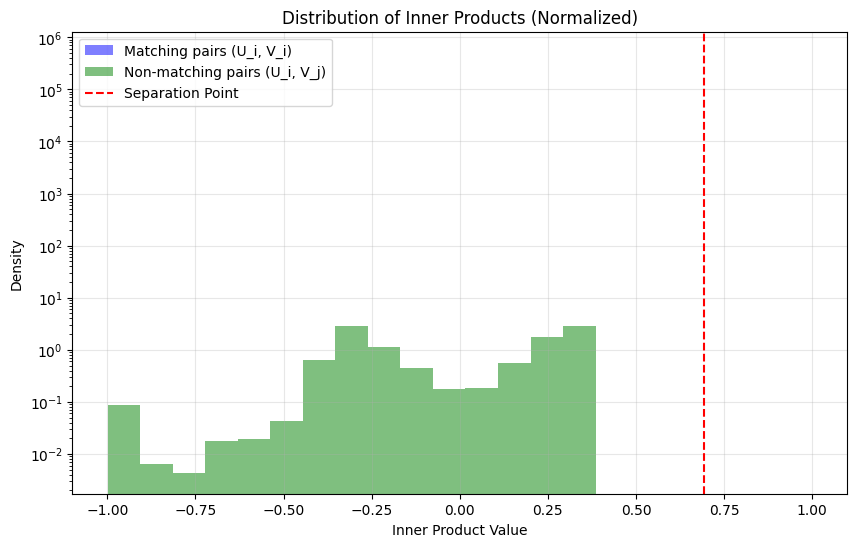


Testing temperature: 30.00
[100/10000]  loss=0.0264  T=30.0000  rb=0.6967
[200/10000]  loss=0.0130  T=30.0000  rb=0.7275
[300/10000]  loss=0.0093  T=30.0000  rb=0.7364
[400/10000]  loss=0.0092  T=30.0000  rb=0.7435
[500/10000]  loss=0.0074  T=30.0000  rb=0.7458
[600/10000]  loss=0.0074  T=30.0000  rb=0.7501
[700/10000]  loss=0.0056  T=30.0000  rb=0.7504
[800/10000]  loss=0.0056  T=30.0000  rb=0.7539
[900/10000]  loss=0.0055  T=30.0000  rb=0.7551
[1000/10000]  loss=0.0055  T=30.0000  rb=0.7558
[1100/10000]  loss=0.0055  T=30.0000  rb=0.7563
[1200/10000]  loss=0.0055  T=30.0000  rb=0.7565
[1300/10000]  loss=0.0055  T=30.0000  rb=0.7566
[1400/10000]  loss=0.0055  T=30.0000  rb=0.7566
[1500/10000]  loss=0.0055  T=30.0000  rb=0.7564
[1600/10000]  loss=0.0037  T=30.0000  rb=0.7491
[1700/10000]  loss=0.0037  T=30.0000  rb=0.7556
[1800/10000]  loss=0.0037  T=30.0000  rb=0.7558
[1900/10000]  loss=0.0037  T=30.0000  rb=0.7556
[2000/10000]  loss=0.0037  T=30.0000  rb=0.7553
[2100/10000]  loss=0.

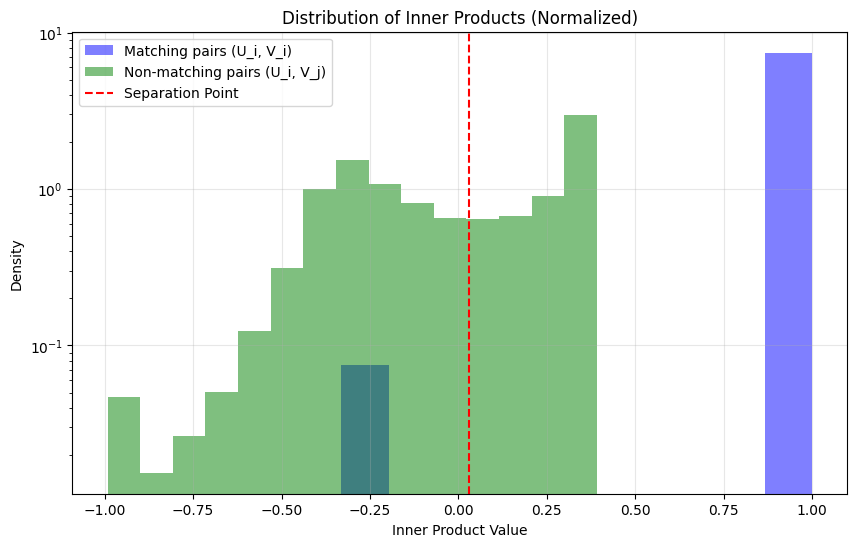


Testing temperature: 40.00
[100/10000]  loss=0.0582  T=40.0000  rb=0.6317
[200/10000]  loss=0.0405  T=40.0000  rb=0.6548
[300/10000]  loss=0.0369  T=40.0000  rb=0.6779
[400/10000]  loss=0.0368  T=40.0000  rb=0.6865
[500/10000]  loss=0.0368  T=40.0000  rb=0.6921
[600/10000]  loss=0.0368  T=40.0000  rb=0.6962
[700/10000]  loss=0.0368  T=40.0000  rb=0.6995
[800/10000]  loss=0.0368  T=40.0000  rb=0.7022
[900/10000]  loss=0.0368  T=40.0000  rb=0.7045
[1000/10000]  loss=0.0368  T=40.0000  rb=0.7065
[1100/10000]  loss=0.0368  T=40.0000  rb=0.7082
[1200/10000]  loss=0.0368  T=40.0000  rb=0.7098
[1300/10000]  loss=0.0368  T=40.0000  rb=0.7112
[1400/10000]  loss=0.0368  T=40.0000  rb=0.7124
[1500/10000]  loss=0.0368  T=40.0000  rb=0.7136
[1600/10000]  loss=0.0368  T=40.0000  rb=0.7147
[1700/10000]  loss=0.0368  T=40.0000  rb=0.7157
[1800/10000]  loss=0.0368  T=40.0000  rb=0.7166
[1900/10000]  loss=0.0368  T=40.0000  rb=0.7175
[2000/10000]  loss=0.0368  T=40.0000  rb=0.7183
[2100/10000]  loss=0.

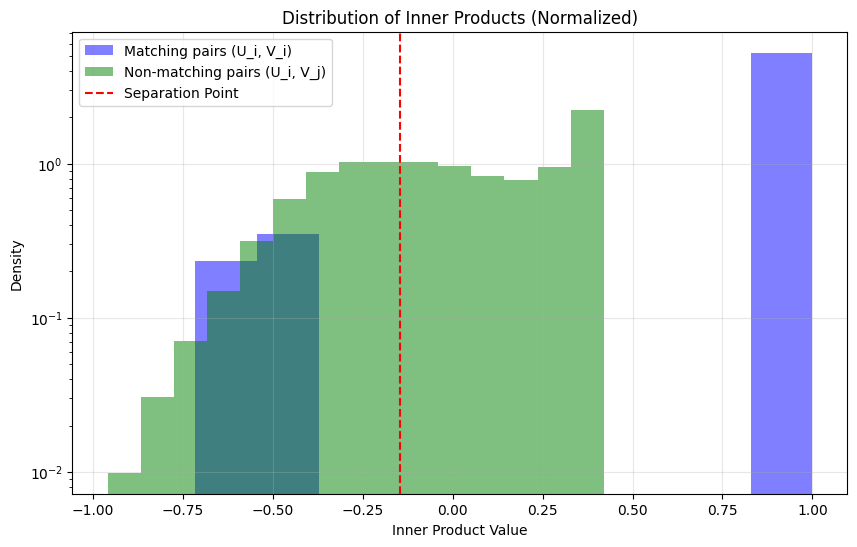


Testing temperature: 50.00
[100/10000]  loss=0.0542  T=50.0000  rb=0.5936
[200/10000]  loss=0.0461  T=50.0000  rb=0.6325
[300/10000]  loss=0.0442  T=50.0000  rb=0.6441
[400/10000]  loss=0.0442  T=50.0000  rb=0.6503
[500/10000]  loss=0.0442  T=50.0000  rb=0.6548
[600/10000]  loss=0.0442  T=50.0000  rb=0.6584
[700/10000]  loss=0.0442  T=50.0000  rb=0.6614
[800/10000]  loss=0.0442  T=50.0000  rb=0.6640
[900/10000]  loss=0.0387  T=50.0000  rb=0.6492
[1000/10000]  loss=0.0350  T=50.0000  rb=0.6538
[1100/10000]  loss=0.0350  T=50.0000  rb=0.6607
[1200/10000]  loss=0.0350  T=50.0000  rb=0.6650
[1300/10000]  loss=0.0350  T=50.0000  rb=0.6682
[1400/10000]  loss=0.0350  T=50.0000  rb=0.6708
[1500/10000]  loss=0.0332  T=50.0000  rb=0.6671
[1600/10000]  loss=0.0332  T=50.0000  rb=0.6716
[1700/10000]  loss=0.0332  T=50.0000  rb=0.6745
[1800/10000]  loss=0.0332  T=50.0000  rb=0.6767
[1900/10000]  loss=0.0332  T=50.0000  rb=0.6785
[2000/10000]  loss=0.0332  T=50.0000  rb=0.6802
[2100/10000]  loss=0.

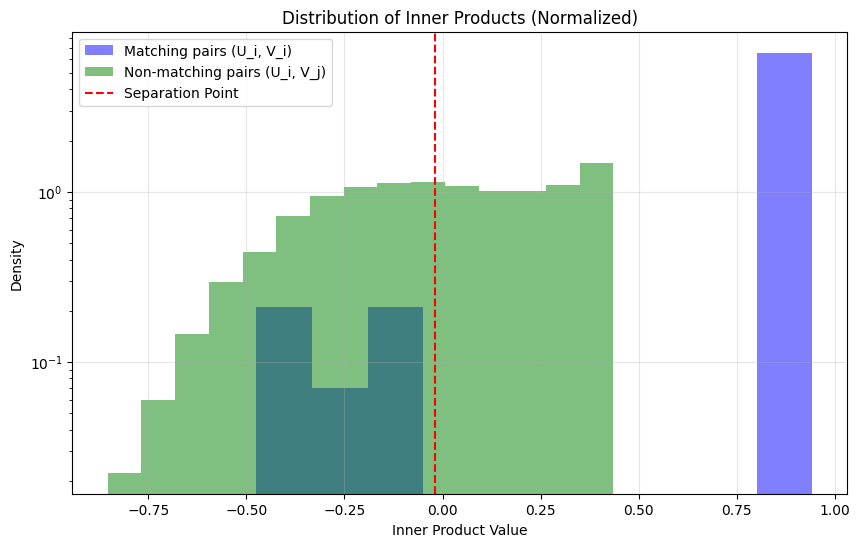


Testing temperature: 60.00
[100/10000]  loss=0.0755  T=60.0000  rb=0.6177
[200/10000]  loss=0.0737  T=60.0000  rb=0.6199
[300/10000]  loss=0.0737  T=60.0000  rb=0.6250
[400/10000]  loss=0.0737  T=60.0000  rb=0.6282
[500/10000]  loss=0.0718  T=60.0000  rb=0.6207
[600/10000]  loss=0.0718  T=60.0000  rb=0.6268
[700/10000]  loss=0.0700  T=60.0000  rb=0.6266
[800/10000]  loss=0.0700  T=60.0000  rb=0.6315
[900/10000]  loss=0.0700  T=60.0000  rb=0.6347
[1000/10000]  loss=0.0700  T=60.0000  rb=0.6370
[1100/10000]  loss=0.0700  T=60.0000  rb=0.6390
[1200/10000]  loss=0.0700  T=60.0000  rb=0.6407
[1300/10000]  loss=0.0626  T=60.0000  rb=0.6243
[1400/10000]  loss=0.0626  T=60.0000  rb=0.6374
[1500/10000]  loss=0.0626  T=60.0000  rb=0.6412
[1600/10000]  loss=0.0626  T=60.0000  rb=0.6438
[1700/10000]  loss=0.0626  T=60.0000  rb=0.6458
[1800/10000]  loss=0.0626  T=60.0000  rb=0.6474
[1900/10000]  loss=0.0626  T=60.0000  rb=0.6487
[2000/10000]  loss=0.0626  T=60.0000  rb=0.6499
[2100/10000]  loss=0.

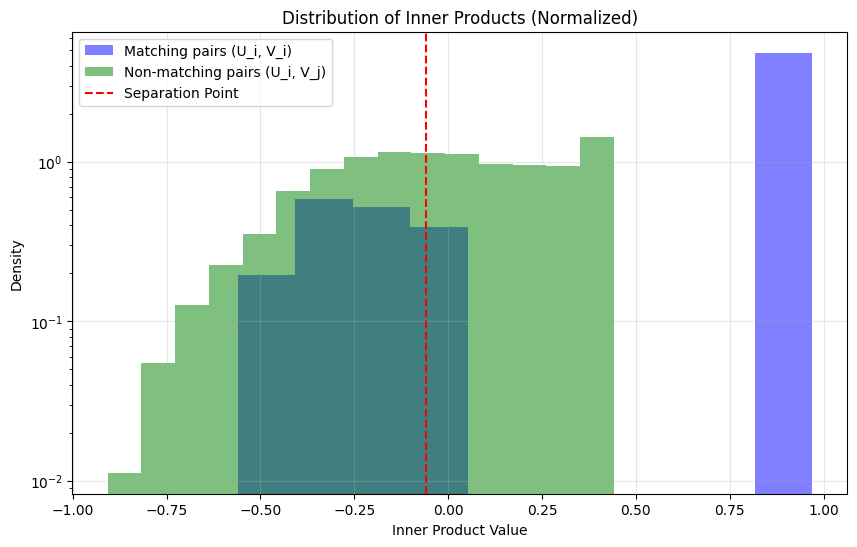


Testing temperature: 70.00
[100/10000]  loss=0.0829  T=70.0000  rb=0.5647
[200/10000]  loss=0.0774  T=70.0000  rb=0.5880
[300/10000]  loss=0.0755  T=70.0000  rb=0.5857
[400/10000]  loss=0.0737  T=70.0000  rb=0.5903
[500/10000]  loss=0.0718  T=70.0000  rb=0.5883
[600/10000]  loss=0.0718  T=70.0000  rb=0.5961
[700/10000]  loss=0.0718  T=70.0000  rb=0.5994
[800/10000]  loss=0.0718  T=70.0000  rb=0.6020
[900/10000]  loss=0.0718  T=70.0000  rb=0.6041
[1000/10000]  loss=0.0718  T=70.0000  rb=0.6059
[1100/10000]  loss=0.0718  T=70.0000  rb=0.6076
[1200/10000]  loss=0.0718  T=70.0000  rb=0.6091
[1300/10000]  loss=0.0718  T=70.0000  rb=0.6104
[1400/10000]  loss=0.0718  T=70.0000  rb=0.6117
[1500/10000]  loss=0.0718  T=70.0000  rb=0.6129
[1600/10000]  loss=0.0718  T=70.0000  rb=0.6140
[1700/10000]  loss=0.0718  T=70.0000  rb=0.6150
[1800/10000]  loss=0.0718  T=70.0000  rb=0.6160
[1900/10000]  loss=0.0718  T=70.0000  rb=0.6170
[2000/10000]  loss=0.0718  T=70.0000  rb=0.6179
[2100/10000]  loss=0.

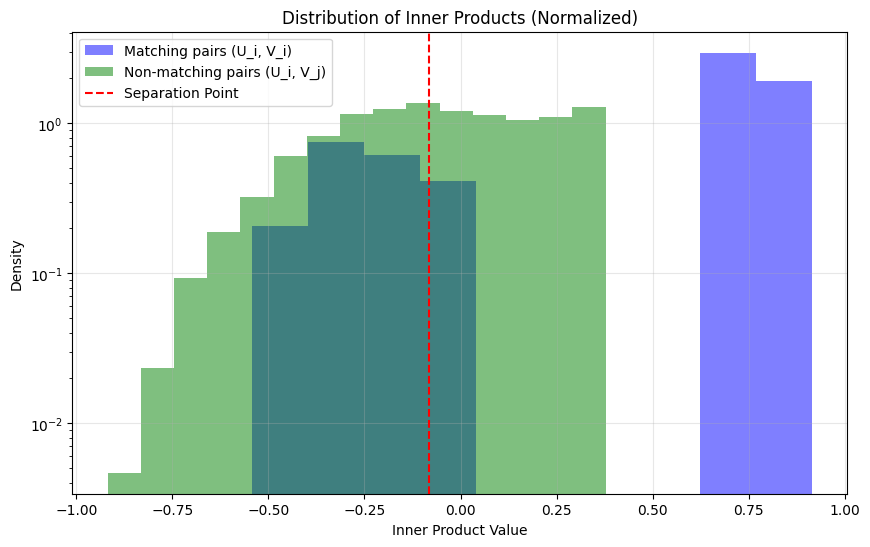


Testing temperature: 80.00
[100/10000]  loss=0.0829  T=80.0000  rb=0.5480
[200/10000]  loss=0.0774  T=80.0000  rb=0.5527
[300/10000]  loss=0.0755  T=80.0000  rb=0.5609
[400/10000]  loss=0.0755  T=80.0000  rb=0.5685
[500/10000]  loss=0.0755  T=80.0000  rb=0.5726
[600/10000]  loss=0.0755  T=80.0000  rb=0.5756
[700/10000]  loss=0.0755  T=80.0000  rb=0.5781
[800/10000]  loss=0.0755  T=80.0000  rb=0.5802
[900/10000]  loss=0.0755  T=80.0000  rb=0.5821
[1000/10000]  loss=0.0755  T=80.0000  rb=0.5838
[1100/10000]  loss=0.0755  T=80.0000  rb=0.5853
[1200/10000]  loss=0.0755  T=80.0000  rb=0.5867
[1300/10000]  loss=0.0755  T=80.0000  rb=0.5880
[1400/10000]  loss=0.0755  T=80.0000  rb=0.5892
[1500/10000]  loss=0.0755  T=80.0000  rb=0.5903
[1600/10000]  loss=0.0755  T=80.0000  rb=0.5914
[1700/10000]  loss=0.0755  T=80.0000  rb=0.5924
[1800/10000]  loss=0.0755  T=80.0000  rb=0.5934
[1900/10000]  loss=0.0755  T=80.0000  rb=0.5943
[2000/10000]  loss=0.0755  T=80.0000  rb=0.5952
[2100/10000]  loss=0.

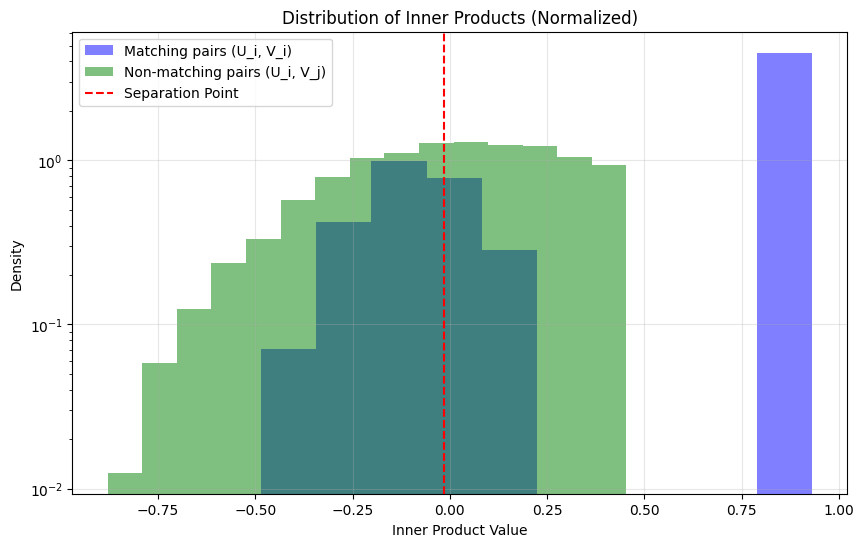


Testing temperature: 90.00
[100/10000]  loss=0.1050  T=90.0000  rb=0.5676
[200/10000]  loss=0.1048  T=90.0000  rb=0.5775
[300/10000]  loss=0.0921  T=90.0000  rb=0.5347
[400/10000]  loss=0.0921  T=90.0000  rb=0.5513
[500/10000]  loss=0.0921  T=90.0000  rb=0.5559
[600/10000]  loss=0.0921  T=90.0000  rb=0.5590
[700/10000]  loss=0.0903  T=90.0000  rb=0.5493
[800/10000]  loss=0.0903  T=90.0000  rb=0.5550
[900/10000]  loss=0.0884  T=90.0000  rb=0.5523
[1000/10000]  loss=0.0884  T=90.0000  rb=0.5595
[1100/10000]  loss=0.0884  T=90.0000  rb=0.5626
[1200/10000]  loss=0.0884  T=90.0000  rb=0.5649
[1300/10000]  loss=0.0884  T=90.0000  rb=0.5668
[1400/10000]  loss=0.0884  T=90.0000  rb=0.5684
[1500/10000]  loss=0.0884  T=90.0000  rb=0.5699
[1600/10000]  loss=0.0884  T=90.0000  rb=0.5712
[1700/10000]  loss=0.0884  T=90.0000  rb=0.5724
[1800/10000]  loss=0.0884  T=90.0000  rb=0.5735
[1900/10000]  loss=0.0884  T=90.0000  rb=0.5745
[2000/10000]  loss=0.0884  T=90.0000  rb=0.5755
[2100/10000]  loss=0.

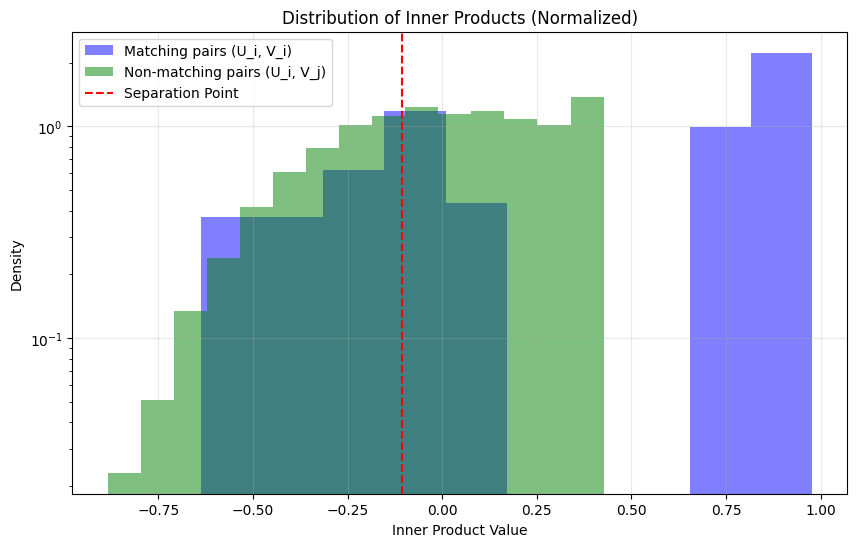


Testing temperature: 100.00
[100/10000]  loss=0.1237  T=100.0000  rb=0.4752
[200/10000]  loss=0.1142  T=100.0000  rb=0.4928
[300/10000]  loss=0.1105  T=100.0000  rb=0.5152
[400/10000]  loss=0.1105  T=100.0000  rb=0.5183
[500/10000]  loss=0.1105  T=100.0000  rb=0.5205
[600/10000]  loss=0.1105  T=100.0000  rb=0.5224
[700/10000]  loss=0.1105  T=100.0000  rb=0.5239
[800/10000]  loss=0.1105  T=100.0000  rb=0.5253
[900/10000]  loss=0.1105  T=100.0000  rb=0.5265
[1000/10000]  loss=0.1105  T=100.0000  rb=0.5277
[1100/10000]  loss=0.1105  T=100.0000  rb=0.5287
[1200/10000]  loss=0.1105  T=100.0000  rb=0.5297
[1300/10000]  loss=0.1105  T=100.0000  rb=0.5306
[1400/10000]  loss=0.1105  T=100.0000  rb=0.5315
[1500/10000]  loss=0.1105  T=100.0000  rb=0.5323
[1600/10000]  loss=0.1105  T=100.0000  rb=0.5331
[1700/10000]  loss=0.1105  T=100.0000  rb=0.5339
[1800/10000]  loss=0.1105  T=100.0000  rb=0.5346
[1900/10000]  loss=0.1105  T=100.0000  rb=0.5353
[2000/10000]  loss=0.1105  T=100.0000  rb=0.5360


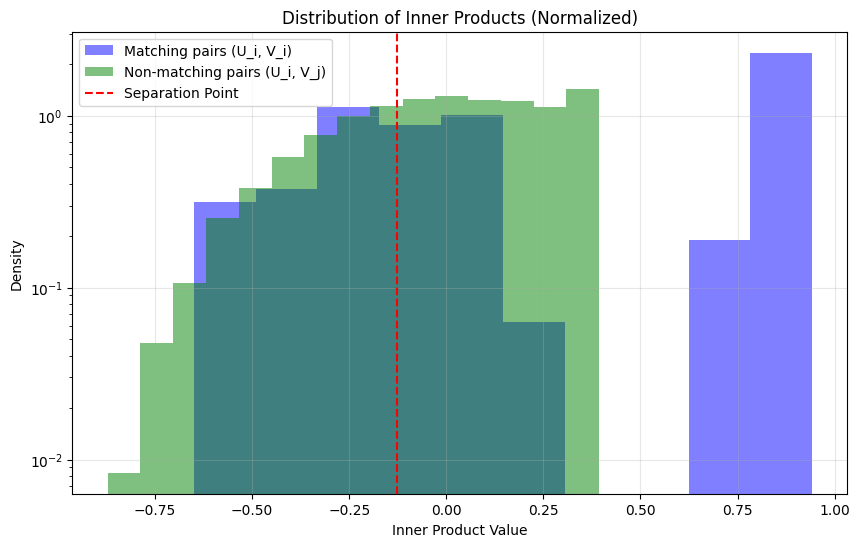

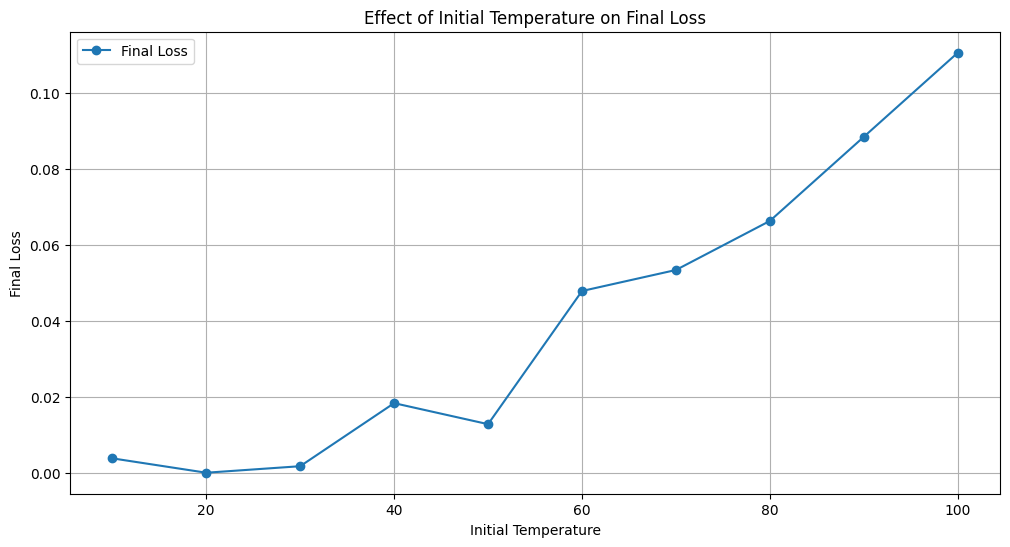

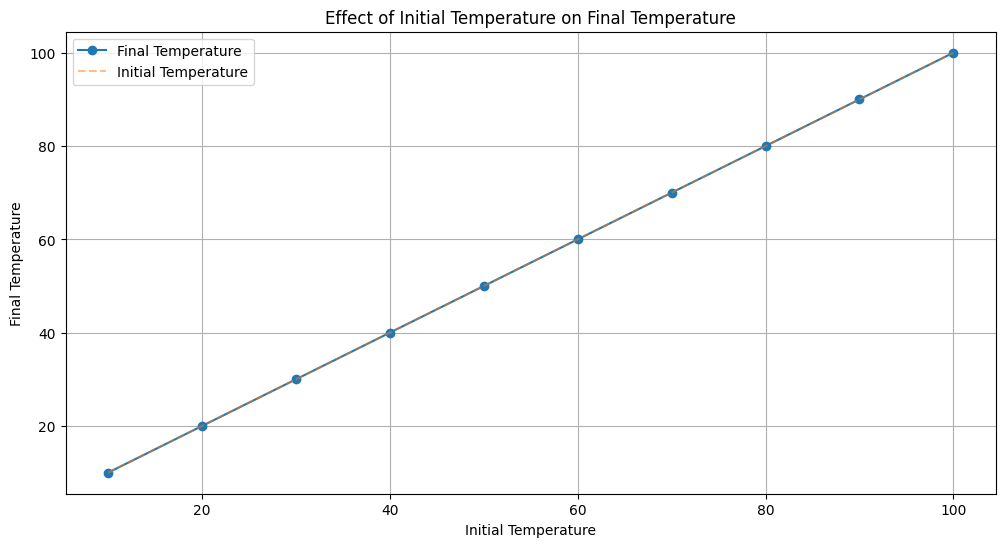

In [21]:
torch.manual_seed(50)

n_classes = 100
dim = 10
n_epochs = int(1e4)
device_str = 'cuda' if torch.cuda.is_available() else 'cpu'

initial_relative_bias = 1.0
bias_is_trainable = True
temperature_is_trainable = False
# Test a range of temperatures
temperatures = np.linspace(10, 100, 10)  # 20 evenly spaced temperatures between 10 and 50
final_losses = []
final_temps = []

print(f"Using device: {device_str}")
print(f"Running experiments with: n_classes={n_classes}, dim={dim}, n_epochs={n_epochs}")

for temp in temperatures:
    print(f"\nTesting temperature: {temp:.2f}")
    
    experiment = SigLIPExperiment(
        n_classes=n_classes,
        dim=dim,
        n_epochs=n_epochs,
        device=device_str
    )

    U_final, V_final, criterion_final, losses_history = experiment.train(
        relative_bias=initial_relative_bias,
        temperature=temp,
        trainable_temp=temperature_is_trainable,
        trainable_bias=bias_is_trainable
    )
    
    final_loss = losses_history[-1]
    final_temp = criterion_final.get_temperature()
    
    final_losses.append(final_loss)
    final_temps.append(final_temp.detach().item())  # Detach and convert to Python scalar
    
    print(f"Final Loss: {final_loss:.4f}")
    print(f"Final Temperature: {final_temp:.4f}")

    experiment.plot_inner_product_gap(U_final, V_final)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(temperatures, final_losses, 'o-', label='Final Loss')
plt.xlabel('Initial Temperature')
plt.ylabel('Final Loss')
plt.title('Effect of Initial Temperature on Final Loss')
plt.grid(True)
plt.legend()
plt.show()

# Plot final temperatures
plt.figure(figsize=(12, 6))
plt.plot(temperatures, final_temps, 'o-', label='Final Temperature')
plt.plot(temperatures, temperatures, '--', label='Initial Temperature', alpha=0.5)
plt.xlabel('Initial Temperature')
plt.ylabel('Final Temperature')
plt.title('Effect of Initial Temperature on Final Temperature')
plt.grid(True)
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

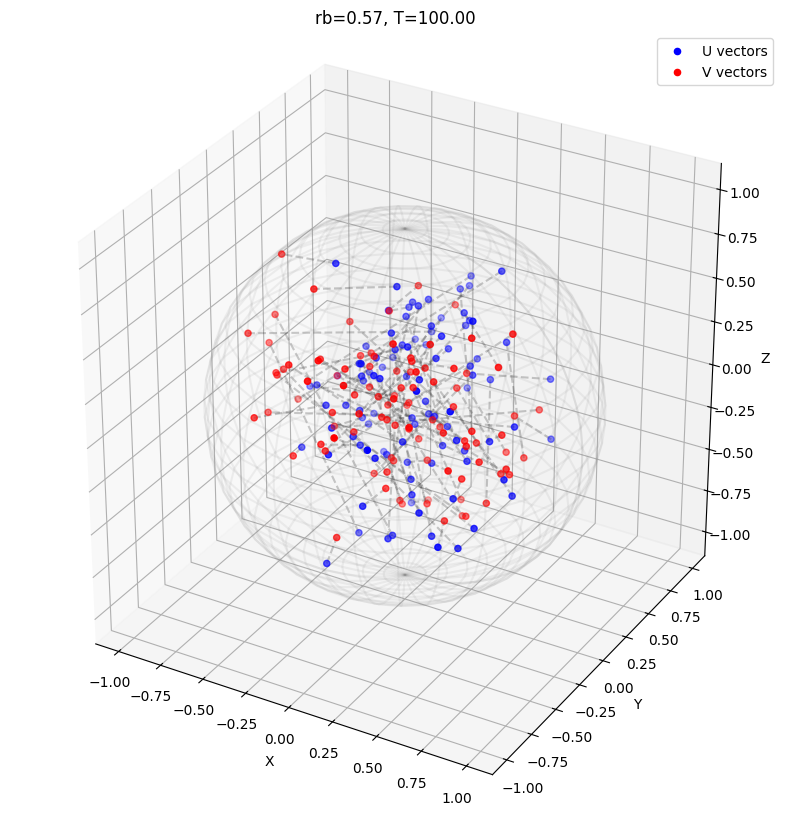

In [18]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
experiment.plot_vectors(
        U_final,
        V_final,
        criterion_final,
        ax=ax
    )
ax.legend()
plt.show